In [ ]:

# Load and preprocess data
data = pd.read_csv('traffic_data.csv')

# Filter numeric columns
numeric_cols = ['car_count', 'waiting_time']
numeric_data = data[numeric_cols]

# Check for NaN values
if numeric_data.isnull().values.any():
    raise ValueError("NaN values present in numeric data. Please handle or remove them.")

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(numeric_data)

# Prepare data for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])  # Using only car_count for Y
    return np.array(X), np.array(Y)

look_back = 3
X, Y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 2)))  # Input shape adjusted to (look_back, 2)
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, Y, epochs=10, batch_size=2, verbose=2)


In [ ]:
# Predict
predictions = model.predict(X)
predictions = np.reshape(predictions, (-1, 1))  # Reshape predictions to match scaler's expectations
predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 1)))))[:, 0]  # Inverse transform with dummy second column

# Evaluate
import matplotlib.pyplot as plt

plt.plot(data['car_count'], label='True Data')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


Epoch 1/10


c:\Users\ajayc\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 - 2s - 60ms/step - loss: 0.0480
Epoch 2/10
35/35 - 0s - 5ms/step - loss: 0.0255
Epoch 3/10
35/35 - 0s - 5ms/step - loss: 0.0244
Epoch 4/10
35/35 - 0s - 5ms/step - loss: 0.0244
Epoch 5/10
35/35 - 0s - 4ms/step - loss: 0.0238
Epoch 6/10
35/35 - 0s - 4ms/step - loss: 0.0228
Epoch 7/10
35/35 - 0s - 4ms/step - loss: 0.0227
Epoch 8/10
35/35 - 0s - 4ms/step - loss: 0.0219
Epoch 9/10
35/35 - 0s - 5ms/step - loss: 0.0197
Epoch 10/10
35/35 - 0s - 5ms/step - loss: 0.0184
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

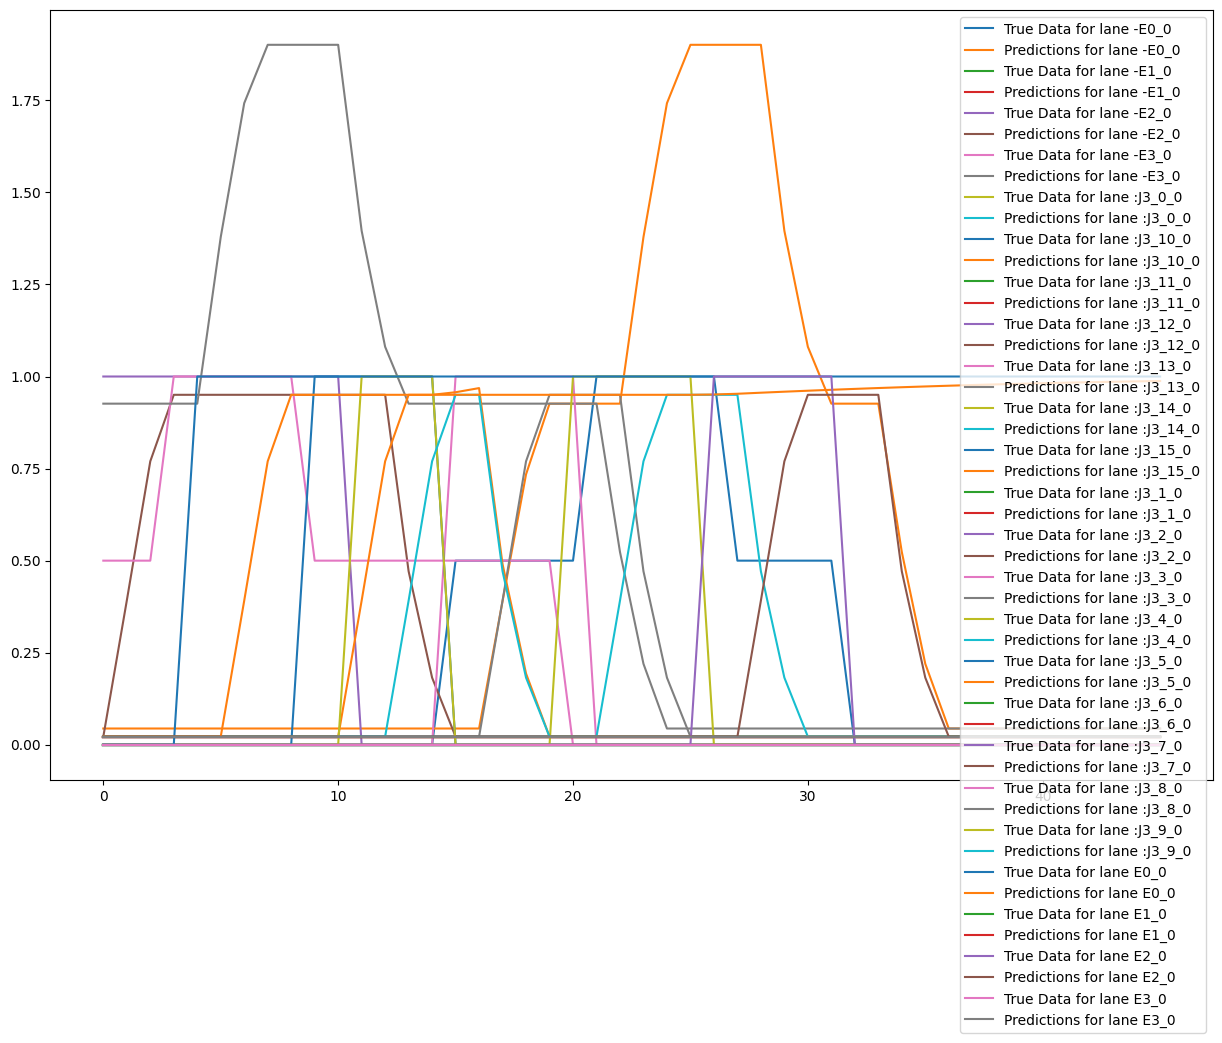

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('traffic_data.csv')

# Filter numeric columns
numeric_cols = ['car_count', 'waiting_time']
lane_ids = data['lane_id'].unique()
scalers = {}

# Normalize data per lane
for lane_id in lane_ids:
    lane_data = data[data['lane_id'] == lane_id][numeric_cols]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scalers[lane_id] = scaler
    data.loc[data['lane_id'] == lane_id, numeric_cols] = scaler.fit_transform(lane_data)

# Prepare data for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])  # Using only car_count for Y
    return np.array(X), np.array(Y)

look_back = 3
X_list, Y_list = [], []

# Create dataset for each lane
for lane_id in lane_ids:
    lane_data = data[data['lane_id'] == lane_id][numeric_cols].values
    X_lane, Y_lane = create_dataset(lane_data, look_back)
    X_list.append(X_lane)
    Y_list.append(Y_lane)

# Combine datasets from all lanes
X = np.concatenate(X_list, axis=0)
Y = np.concatenate(Y_list, axis=0)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 2)))  # Input shape adjusted to (look_back, 2)
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, Y, epochs=10, batch_size=32, verbose=2)

# Predict for each lane
predictions_list = []

for lane_id in lane_ids:
    lane_data = data[data['lane_id'] == lane_id][numeric_cols].values
    X_lane, _ = create_dataset(lane_data, look_back)
    X_lane = np.reshape(X_lane, (X_lane.shape[0], X_lane.shape[1], X_lane.shape[2]))
    
    predictions = model.predict(X_lane)
    predictions = np.reshape(predictions, (-1, 1))  # Reshape predictions to match scaler's expectations
    scaler = scalers[lane_id]
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 1)))))[:, 0]  # Inverse transform with dummy second column
    predictions_list.append(predictions)

# Combine predictions for visualization
all_predictions = np.concatenate(predictions_list)

# Evaluate and plot results for each lane
plt.figure(figsize=(15, 10))

for lane_id in lane_ids:
    lane_data = data[data['lane_id'] == lane_id]
    true_data = lane_data['car_count'].values[look_back+1:]  # Adjust for look_back
    predictions = all_predictions[:len(true_data)]
    all_predictions = all_predictions[len(true_data):]

    plt.plot(true_data, label=f'True Data for lane {lane_id}')
    plt.plot(predictions, label=f'Predictions for lane {lane_id}')

plt.legend()
plt.show()
